# Python BI project
## The goal of this project is to decide where (geographical position) to start/found a startup.
### Startup details (simulation that we want to found it):
* **Name**: Habits.AI
* **Web page**: www.habits.ai
* **Description:** B2B platform for well-being and productivity. Through artificial intelligence, gamification, and behavioral science, we build healthy cultures that increase your employees’ engagement, productivity, loyalty and health.
* **Category**: Digital Health, well-being, B2B, technology, artificial intelligence & machine learning.
* **Important details/questions about the place**:
    * Want to be close to other tech companies.
    * There should be an entrepreneur ecosystem around the city and country (venture capitals, coworkings, universities, etc.).
    * There are big companies around (potencial clients).
    * How many startups fails in the city/country?

## First step: organize data about startups around the world that are registered in Crunchbase
Dataset url: https://www.kaggle.com/arindam235/startup-investments-crunchbase

I imported the data set to MongoDB so I can practice how to use this tool.

In [897]:
# importar librerias
import pymongo
import pandas as pd
import folium
from folium import plugins
import seaborn as sns
import matplotlib.pyplot as plt
import time
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import numpy as np

In [354]:
# crear el cliente de Mongo
cliente = pymongo.MongoClient()

In [355]:
# comprobar conexión
cliente

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

In [356]:
# llamar a la base de datos
bbdd = cliente.pythonBIproject

In [357]:
# llamar a la colección
startups_mongo = bbdd.StartUpInvestments
startups_mongo

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'pythonBIproject'), 'StartUpInvestments')

In [358]:
# llamar solo a las startups que SÍ tienen ciudad y evitar que nos llegue alguna información que no la vamos a usar
startups_lst = list(startups_mongo.find({"city":{"$ne": ""}},
                   {"_id":0,"permalink":0,'round_C': 0,'round_D': 0,
                    'round_E': 0,'round_F': 0,'round_G': 0,'round_H': 0,
                    'post_ipo_equity':0,'post_ipo_debt':0,'secondary_market':0,
                   'product_crowdfunding':0,'debt_financing':0,'convertible_note':0,
                   'equity_crowdfunding':0,'undisclosed':0,'private_equity':0}))

In [359]:
# crear un dataframe con la lista guardada
startups = pd.DataFrame(startups_lst)

In [360]:
# muestra del dataframe de startups
startups.head()

,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,seed,venture,angel,grant,round_A,round_B
0,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City,New York,1,2012-06-01 00:00:00,2012-06,2012-Q2,2012,2012-06-30 00:00:00,2012-06-30 00:00:00,1750000,0.0,0,0,0,0
1,&TV Communications,http://enjoyandtv.com,|Games|,Games,"40,00,000",operating,USA,CA,Los Angeles,Los Angeles,2,1970-01-01 00:00:00,,,,2010-06-04 00:00:00,2010-09-23 00:00:00,0,4000000.0,0,0,0,0
2,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,"40,000",operating,EST,,Tallinn,Tallinn,1,2012-10-26 00:00:00,2012-10,2012-Q4,2012,2012-08-09 00:00:00,2012-08-09 00:00:00,40000,0.0,0,0,0,0
3,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,"15,00,000",operating,GBR,,London,London,1,2011-04-01 00:00:00,2011-04,2011-Q2,2011,2011-04-01 00:00:00,2011-04-01 00:00:00,1500000,0.0,0,0,0,0
4,-R- Ranch and Mine,,|Tourism|Entertainment|Games|,Tourism,"60,000",operating,USA,TX,Dallas,Fort Worth,2,2014-01-01 00:00:00,2014-01,2014-Q1,2014,2014-08-17 00:00:00,2014-09-26 00:00:00,0,0.0,0,0,0,0


In [361]:
'''Hay algunas ciudades en "city" que tienen el simbolo �, si lo tiene, vamos
a reemplazar por la region'''

startups["city"] = startups.apply(lambda x: x["region"] if "�" in x["city"] else x["city"],
                                  axis=1)


In [362]:
# hay dos nombres de columnas con espacios extras
startups.columns = [i.strip() for i in list(startups.columns)]
startups.columns

Index(['name', 'homepage_url', 'category_list', 'market', 'funding_total_usd',
       'status', 'country_code', 'state_code', 'region', 'city',
       'funding_rounds', 'founded_at', 'founded_month', 'founded_quarter',
       'founded_year', 'first_funding_at', 'last_funding_at', 'seed',
       'venture', 'angel', 'grant', 'round_A', 'round_B'],
      dtype='object')

In [363]:
# vamos a entender qué categorias de startups hay
lst = startups["market"].value_counts()
#print(lst.to_string()) #imprimir la lista completa de todas las categorias de  la tabla

In [364]:
# todas las categorias tienen un espacio antes y atras de cada palabra, vamos a limpiar
startups["market"] = startups["market"].apply(lambda x: x.strip())

In [413]:
# vamos a filtrar el dataframe a solo estás categorias relacionadas a la startup que queremos fundar: 
cat_lst = ["Apps","Technology","SaaS","Medical","Health and Wellness","Health Care","Mobile",
           "Software","Medical Devices","Internet of Things","Health Care Information Technology",
           "Productivity Software","Machine Learning","Artificial Intelligence","Healthcare Services",
           "Mobile Health","Health and Insurance"]

startups_filt = startups[startups["market"].isin(cat_lst)]

# muestra de la tabla
startups_filt.head()

,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,seed,venture,angel,grant,round_A,round_B
5,.Club Domains,http://nic.club/,|Software|,Software,"70,00,000",,USA,FL,Ft. Lauderdale,Oakland Park,1,2011-10-10 00:00:00,2011-10,2011-Q4,2011,2013-05-31 00:00:00,2013-05-31 00:00:00,0,7000000.0,0,0,0,7000000
7,004 Technologies,http://004gmbh.de/en/004-interact,|Software|,Software,-,operating,USA,IL,"Springfield, Illinois",Champaign,1,2010-01-01 00:00:00,2010-01,2010-Q1,2010,2014-07-24 00:00:00,2014-07-24 00:00:00,0,0.0,0,0,0,0
10,1-4 All,,|Entertainment|Games|Software|,Software,-,operating,USA,NC,NC - Other,Connellys Springs,1,1970-01-01 00:00:00,,,,2013-04-21 00:00:00,2013-04-21 00:00:00,0,0.0,0,0,0,0
11,1-800-DENTIST,http://www.1800dentist.com,|Health and Wellness|,Health and Wellness,-,operating,USA,CA,Los Angeles,Los Angeles,1,1986-01-01 00:00:00,1986-01,1986-Q1,1986,2010-08-19 00:00:00,2010-08-19 00:00:00,0,0.0,0,0,0,0
12,1-800-DOCTORS,http://1800doctors.com,|Health and Wellness|,Health and Wellness,"17,50,000",operating,USA,NJ,Newark,Iselin,1,1984-01-01 00:00:00,1984-01,1984-Q1,1984,2011-03-02 00:00:00,2011-03-02 00:00:00,0,0.0,0,0,0,0


## Second step: include the latitud and longitud of each city in the previous DataFrame
I will use another database that have latitud and longitud of cities.
The goal is to show the heatmap of the previous dataframe.
https://www.kaggle.com/dataset/f66386cd35268fd2ae9c7c03e6e4d93c9b1607265c1adef13f99a76e420be997/version/1


In [402]:
#extraer CSV con base de datos de ciudades
cities = pd.read_csv('Data/worldcities.csv')

In [403]:
#muestra de cities
cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6850,139.7514,Japan,JP,JPN,Tōkyō,primary,35676000.0,1392685764
1,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922.0,1840034016
2,Mexico City,Mexico City,19.4424,-99.1310,Mexico,MX,MEX,Ciudad de México,primary,19028000.0,1484247881
3,Mumbai,Mumbai,19.0170,72.8570,India,IN,IND,Mahārāshtra,admin,18978000.0,1356226629
4,São Paulo,Sao Paulo,-23.5587,-46.6250,Brazil,BR,BRA,São Paulo,admin,18845000.0,1076532519


In [404]:
# solo se van a quedar las columnas de ["city_ascii","lat","lng","iso3"]
cities = cities[["city_ascii","lat","lng","iso3"]]

In [405]:
#renombramos la columna de "city_ascii" por "city" y "iso3" por "country_code"
cities.rename(columns={"city_ascii":"city","iso3":"country_code"}, inplace=True)

In [407]:
'''revisando la tabla, hay varias ciudades que estan repetidas, eliminamos los
registros repetidos y solo dejamos el primer registro'''

cities.drop_duplicates(subset=['city', 'country_code'], keep='first',inplace=True)

In [410]:
#muestra de la tabla final
cities.head()

,city,lat,lng,country_code
0,Tokyo,35.6850,139.7514,JPN
1,New York,40.6943,-73.9249,USA
2,Mexico City,19.4424,-99.1310,MEX
3,Mumbai,19.0170,72.8570,IND
4,Sao Paulo,-23.5587,-46.6250,BRA


In [414]:
# hacemos el merge de startups_filt con cities (latitude y longitud)
startups_filt = pd.merge(startups_filt,cities, on=["country_code","city"],how='left')

In [418]:
# muestra de la tabla
startups_filt.head()

,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,seed,venture,angel,grant,round_A,round_B,lat,lng
0,.Club Domains,http://nic.club/,|Software|,Software,"70,00,000",,USA,FL,Ft. Lauderdale,Oakland Park,1,2011-10-10 00:00:00,2011-10,2011-Q4,2011,2013-05-31 00:00:00,2013-05-31 00:00:00,0,7000000.0,0,0,0,7000000,26.1780,-80.1528
1,004 Technologies,http://004gmbh.de/en/004-interact,|Software|,Software,-,operating,USA,IL,"Springfield, Illinois",Champaign,1,2010-01-01 00:00:00,2010-01,2010-Q1,2010,2014-07-24 00:00:00,2014-07-24 00:00:00,0,0.0,0,0,0,0,40.1144,-88.2735
2,1-4 All,,|Entertainment|Games|Software|,Software,-,operating,USA,NC,NC - Other,Connellys Springs,1,1970-01-01 00:00:00,,,,2013-04-21 00:00:00,2013-04-21 00:00:00,0,0.0,0,0,0,0,NaN,NaN
3,1-800-DENTIST,http://www.1800dentist.com,|Health and Wellness|,Health and Wellness,-,operating,USA,CA,Los Angeles,Los Angeles,1,1986-01-01 00:00:00,1986-01,1986-Q1,1986,2010-08-19 00:00:00,2010-08-19 00:00:00,0,0.0,0,0,0,0,34.1139,-118.4068
4,1-800-DOCTORS,http://1800doctors.com,|Health and Wellness|,Health and Wellness,"17,50,000",operating,USA,NJ,Newark,Iselin,1,1984-01-01 00:00:00,1984-01,1984-Q1,1984,2011-03-02 00:00:00,2011-03-02 00:00:00,0,0.0,0,0,0,0,40.5702,-74.3170


In [445]:
# generamos el heatmapp
mapa=folium.Map([31.653830718,9.17416597],zoom_start=2)
lat_long = startups_filt[["lat","lng"]].dropna().values
mapa.add_child(plugins.HeatMap(lat_long, radius=15))

# guardamos el mapa como imagen
mapa.save("startups_in_the_world.html")

# se ve que hay una mayor concentración de startups en USA, Europa y Asia
mapa

In [470]:
# Para seguir usando el dataframe en los siguientes pasos, llenamos los NaN con "-"

startups_filt.fillna("-",inplace=True)

## Third step: Organize the dataframe (startups_filt) by NUMBER OF STARTUPS in each Country/City
I will use a pivot table to complete this step

In [552]:
'''hacemos una pivot table en donde contemos cuantas startups de cada categoria
seleccionada hay en cada ciudad/pais'''

cities_startups = startups_filt.pivot_table(index = ['country_code','city'],
                          columns = "market",
                          aggfunc = "count",
                          margins = True,
                          fill_value = 0).reset_index()
#muestra de la tabla
cities_startups.head()

country_code           city angel                                      \
market                              Apps Artificial Intelligence Health Care   
0               ARE          Dubai     1                       0           0   
1               ARG   Buenos Aires     0                       0           1   
2               ARG   Cordoba, ARG     0                       1           0   
3               ARG    Finca Elisa     0                       0           0   
4               ARG  Mar Del Plata     0                       0           0   

                                                                \
market Health Care Information Technology Health and Insurance   
0                                       0                    0   
1                                       0                    0   
2                                       0                    0   
3                                       0                    0   
4                                       0                    0   

                                                                   \
market Health and Wellness Healthcare Services Internet of Things   
0                        0                   0                  0   
1                        0                   0                  0   
2                        0                   0                  0   
3                        0                   0                  0   
4                        0                   0                  0   

                                                                      \
market Machine Learning Medical Medical Devices Mobile Mobile Health   
0                     0       0               0      3             0   
1                     0       0               0      9             0   
2                     0       0               0      0             0   
3                     0       0               0      0             0   
4                     0       0               0      1             0   

                                                          category_list  \
market Productivity Software SaaS Software Technology All          Apps   
0                          0    0        1          0   5             1   
1                          0    0        6          0  16             0   
2                          0    0        0          0   1             0   
3                          0    0        1          0   1             0   
4                          0    0        0          0   1             0   

                                                                               \
market Artificial Intelligence Health Care Health Care Information Technology   
0                            0           0                                  0   
1                            0           1                                  0   
2                            1           0                                  0   
3                            0           0                                  0   
4                            0           0                                  0   

                                                                     \
market Health and Insurance Health and Wellness Healthcare Services   
0                         0                   0                   0   
1                         0                   0                   0   
2                         0                   0                   0   
3                         0                   0                   0   
4                         0                   0                   0   

                                                                           \
market Internet of Things Machine Learning Medical Medical Devices Mobile   
0                       0                0       0               0      3   
1                       0                0       0               0      9   
2                       0                0       0               0      0   
3                

In [553]:
'''la pivot table nos está generando un count de categorias por cada columna de la tabla
(con los mismos valores), solo necesitamos las primeras 20 columnas y acomodar bien los
nombres de las columnas'''
cities_startups = cities_startups.iloc[:,:20].droplevel(0, axis=1).drop(1755)

col = ['country_code', 'city', 'Apps', 'Artificial Intelligence',
       'Health Care', 'Health Care Information Technology',
       'Health and Insurance', 'Health and Wellness', 'Healthcare Services',
       'Internet of Things', 'Machine Learning', 'Medical', 'Medical Devices',
       'Mobile', 'Mobile Health', 'Productivity Software', 'SaaS', 'Software',
       'Technology', 'All']

cities_startups.columns = col

In [554]:
#verificamos los nombres de columnas
cities_startups.columns

Index(['country_code', 'city', 'Apps', 'Artificial Intelligence',
       'Health Care', 'Health Care Information Technology',
       'Health and Insurance', 'Health and Wellness', 'Healthcare Services',
       'Internet of Things', 'Machine Learning', 'Medical', 'Medical Devices',
       'Mobile', 'Mobile Health', 'Productivity Software', 'SaaS', 'Software',
       'Technology', 'All'],
      dtype='object')

In [555]:
#muestra de la tabla
cities_startups.sort_values("All", ascending=False).head()

,country_code,city,Apps,Artificial Intelligence,Health Care,Health Care Information Technology,Health and Insurance,Health and Wellness,Healthcare Services,Internet of Things,Machine Learning,Medical,Medical Devices,Mobile,Mobile Health,Productivity Software,SaaS,Software,Technology,All
1515,USA,San Francisco,21,1,35,5,1,59,2,10,4,6,3,152,0,8,21,213,18,559
1334,USA,New York,13,1,34,2,0,38,0,2,0,7,3,96,0,1,11,165,11,384
393,GBR,London,10,0,13,2,0,5,0,1,2,3,0,55,0,2,8,82,11,194
1402,USA,Palo Alto,6,2,15,2,0,12,0,2,0,0,0,33,2,2,7,66,5,154
745,USA,Austin,0,0,14,3,0,8,0,1,0,3,1,23,0,1,3,88,5,150


In [556]:
# Vamos a quedarnos solo con ["country_code","city","All"]
cities_startups = cities_startups[["country_code","city","All"]].sort_values("All", ascending=False)
cities_startups.columns = ["country_code","city","No. of startups"]

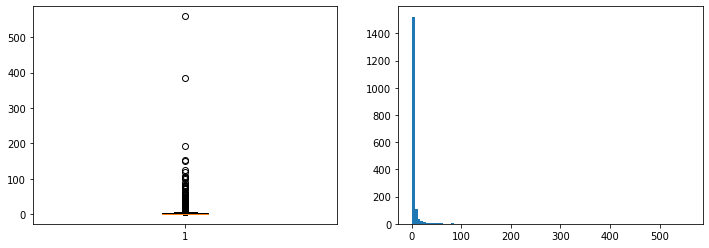

In [557]:
# vamos a ver la distibución del número de startups
fig,ax = plt.subplots(1,2,figsize =(12,4))

ax[0].boxplot(cities_startups["No. of startups"])
ax[1].hist(cities_startups["No. of startups"], bins=100);

#Se observan que hay muchos outliers, la variación de startups en cada ciudad es muy amplia

In [558]:
# La estadistica descriptiva de la columna confirma que hay muchos outliers

cities_startups["No. of startups"].describe()

count    1755.000000
mean        5.238746
std        20.486987
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       559.000000
Name: No. of startups, dtype: float64

In [591]:
'''vamos a generar una evaluación del número de startups en cada ciudad.
La columna tendrá valores del 1 al 5:
    5 = más de 100 startups
    4 = entre 20 y 100
    3 = entre 5 y 20
    2 = entre 2 y 5
    1 = 1 startup'''

def evaluation_number(x):
    if x>=100:
        return 5
    elif x>=20:
        return 4
    elif x>=5:
        return 3
    elif x>=2:
        return 2
    else:
        return 1

cities_startups["No. of startups - Evaluation (1-5)"] = cities_startups["No. of startups"].apply(lambda x: evaluation_number(x))


In [592]:
# muestra de la tabla final
cities_startups

,country_code,city,No. of startups,No. of startups - Evaluation (1-5)
1515,USA,San Francisco,559,5
1334,USA,New York,384,5
393,GBR,London,194,5
1402,USA,Palo Alto,154,5
745,USA,Austin,150,5
...,...,...,...,...
676,SWE,Falun,1,1
672,SLV,San Salvador,1,1
670,SGP,Midview City,1,1
669,RUS,Yekaterinburg,1,1


## Fourth step: Organize the dataframe (startups_filt) by FUNDING TOTAL (USD) in each Country/City
I will use a pivot table to complete this step

In [565]:
''' la columna de funding_total_usd tiene comas en los valores para facilitar la lectura,
se van a quitar para evitar problemas en los cálculos'''

startups_filt["funding_total_usd"] = startups_filt["funding_total_usd"].apply(lambda x: 0 if x=="-" else x.strip().replace(",",""))

In [566]:
# convertimos la columna de funding a tipo number
startups_filt["funding_total_usd"] = pd.to_numeric(startups_filt["funding_total_usd"])

In [579]:
'''hacemos una pivot table en donde sacamos el promedio de funding en USD
de las startups en cada ciudad/pais'''

cities_funding = startups_filt.pivot_table(index = ['country_code','city'],
                          values = "funding_total_usd",
                          aggfunc = "mean",
                          fill_value = 0).reset_index().sort_values("funding_total_usd", ascending=False)
#muestra de la tabla
cities_funding.head()

,country_code,city,funding_total_usd
1092,USA,Hempstead,436180930.0
1029,USA,Fort Myers,325000000.0
136,CHN,Chaoyang,279881556.0
617,NLD,Leiden,249136400.0
1036,USA,Frankfort,200000000.0


In [580]:
#convertimos el valor de funding a entero
cities_funding["funding_total_usd"] = cities_funding["funding_total_usd"].apply(lambda x: int(x))

In [581]:
#muestra de la tabla
cities_funding

,country_code,city,funding_total_usd
1092,USA,Hempstead,436180930
1029,USA,Fort Myers,325000000
136,CHN,Chaoyang,279881556
617,NLD,Leiden,249136400
1036,USA,Frankfort,200000000
...,...,...,...
713,USA,Allison Park,0
238,DNK,Risskov,0
236,DNK,Holstebro,0
233,DNK,Haderslev,0


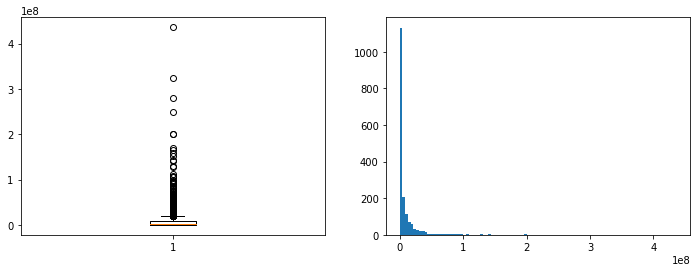

In [582]:
# vamos a ver la distibución del funding de startups
fig,ax = plt.subplots(1,2,figsize =(12,4))

ax[0].boxplot(cities_funding["funding_total_usd"])
ax[1].hist(cities_funding["funding_total_usd"], bins=100);

#Se observan que hay muchos outliers, la variación de funding en cada ciudad es muy amplia

In [590]:
# La estadistica descriptiva de la columna confirma que hay muchos outliers

cities_funding["funding_total_usd"].describe()

count        1755.00
mean      8942415.65
std      23714781.69
min             0.00
25%        300000.00
50%       1856057.00
75%       8000000.00
max     436180930.00
Name: funding_total_usd, dtype: float64

In [595]:
'''vamos a generar una evaluación del funding promedio en cada ciudad.
La columna va a ir del 1 al 5:
    5 = igual o mayor al percentil 80%
    4 = igual o mayor al percentil 60%
    3 = igual o mayor al percentil 40%
    2 = igual o mayor al percentil 20%
    1 = igual o mayor al percentil 0%
'''

def evaluation_funding(x):
    if x>=cities_funding["funding_total_usd"].quantile(0.8):
        return 5
    elif x>=cities_funding["funding_total_usd"].quantile(0.6):
        return 4
    elif x>=cities_funding["funding_total_usd"].quantile(0.4):
        return 3
    elif x>=cities_funding["funding_total_usd"].quantile(0.2):
        return 2
    else:
        return 1

cities_funding["Funding Evaluation (1-5)"] = cities_funding["funding_total_usd"].apply(lambda x: evaluation_funding(x))


In [597]:
#muestra de la tabla final
cities_funding

,country_code,city,funding_total_usd,Funding Evaluation (1-5)
1092,USA,Hempstead,436180930,5
1029,USA,Fort Myers,325000000,5
136,CHN,Chaoyang,279881556,5
617,NLD,Leiden,249136400,5
1036,USA,Frankfort,200000000,5
...,...,...,...,...
713,USA,Allison Park,0,1
238,DNK,Risskov,0,1
236,DNK,Holstebro,0,1
233,DNK,Haderslev,0,1


## Fifth step: Organize the dataframe (startups_filt) by Status (operating or closed) in each Country/City
I will use a pivot table to complete this step

In [599]:
# revisamos como se compone está columna
startups_filt["status"].value_counts()

operating    7803
acquired      792
closed        437
              162
Name: status, dtype: int64

In [601]:
# vamos a cambiar "acquired" por "operating" y las celdas vacias las pondremos como "closed"
startups_filt["status"] = startups_filt["status"].replace(["acquired",""],["operating","closed"])

In [602]:
startups_filt["status"].value_counts()

operating    8595
closed        599
Name: status, dtype: int64

In [625]:
'''hacemos una pivot table en donde vemos cuantas startups operan y cuantas han cerrado en
cada ciudad/pais'''

cities_failure = startups_filt.pivot_table(index = ['country_code','city'],
                          columns = "status",
                          aggfunc = "count",
                          fill_value = 0).reset_index()
#muestra de la tabla
cities_failure.head()

country_code           city  angel           category_list            \
status                             closed operating        closed operating   
0               ARE          Dubai      0         5             0         5   
1               ARG   Buenos Aires      2        14             2        14   
2               ARG   Cordoba, ARG      0         1             0         1   
3               ARG    Finca Elisa      0         1             0         1   
4               ARG  Mar Del Plata      0         1             0         1   

       first_funding_at           founded_at           founded_month  \
status           closed operating     closed operating        closed   
0                     0         5          0         5             0   
1                     2        14          2        14             2   
2                     0         1          0         1             0   
3                     0         1          0         1             0   
4                     0         1          0         1             0   

                 founded_quarter           founded_year            \
status operating          closed operating       closed operating   
0              5               0         5            0         5   
1             14               2        14            2        14   
2              1               0         1            0         1   
3              1               0         1            0         1   
4              1               0         1            0         1   

       funding_rounds           funding_total_usd            grant            \
status         closed operating            closed operating closed operating   
0                   0         5                 0         5      0         5   
1                   2        14                 2        14      2        14   
2                   0         1                 0         1      0         1   
3                   0         1                 0         1      0         1   
4                   0         1                 0         1      0         1   

       homepage_url           last_funding_at              lat            \
status       closed operating          closed operating closed operating   
0                 0         5               0         5      0         5   
1                 2        14               2        14      2        14   
2                 0         1               0         1      0         1   
3                 0         1               0         1      0         1   
4                 0         1               0         1      0         1   

          lng           market             name           region            \
status closed operating closed operating closed operating closed operating   
0           0         5      0         5      0         5      0         5   
1           2        14      2        14      2        14      2        14   
2           0         1      0         1      0         1      0         1   
3           0         1      0         1      0         1      0         1   
4           0         1      0         1      0         1      0         1   

       round_A           round_B             seed           state_code  \
status  closed operating  closed operating closed operating     closed   
0            0         5       0         5      0         5          0   
1            2        14       2        14      2        14          2   
2            0         1       0         1      0         1          0   
3            0         1       0         1      0         1          0   
4            0         1       0         1      0         1          0   

                 venture            
status operating  closed operating  
0              5       0         5  
1             14       2        14  
2              1       0         1  
3              1       0         1  
4              1       0         1

In [626]:
'''la pivot table nos está generando un count de status por cada columna de la tabla
(con los mismos valores), solo necesitamos las primeras 4 columnas y acomodar bien los
nombres de las columnas'''
cities_failure = cities_failure.iloc[:,:4].droplevel(0, axis=1)

col = ['country_code', 'city', 'closed','operating']

cities_failure.columns = col

In [627]:
# Muestra de la tabla

cities_failure.head()

,country_code,city,closed,operating
0,ARE,Dubai,0,5
1,ARG,Buenos Aires,2,14
2,ARG,"Cordoba, ARG",0,1
3,ARG,Finca Elisa,0,1
4,ARG,Mar Del Plata,0,1


In [628]:
#creamos una columna con el porcentaje de fracaso de startups por ciudad
cities_failure["failure_rate"] = (cities_failure["closed"]/(cities_failure["closed"]+cities_failure["operating"]))*100


In [631]:
# revisamos la estadistica descriptiva de la tasa de fracaso
cities_failure["failure_rate"].describe()

'''en la mayoria de ciudades la tasa es muy baja (igual o cercana a 0)
para un futuro ejercicio, se debe buscar una base de datos con datos más reales
de fracaso'''

count   1755.00
mean       6.47
std       20.60
min        0.00
25%        0.00
50%        0.00
75%        0.00
max      100.00
Name: failure_rate, dtype: float64

In [648]:
'''vamos a generar una evaluación del la tasa de fracaso/cierre promedio en cada ciudad.
La columna va a ir del 1 al 5:
    5 = igual a 0%
    4 = igual o menor a 5%
    3 = igual o menor a 20%
    2 = igual o menor a 50%
    1 = mayor a 50%
'''

def evaluation_failure(x):
    if x==0:
        return 5
    elif x<=5 :
        return 4
    elif x<=20:
        return 3
    elif x<=50:
        return 2
    else:
        return 1

cities_failure["Failure Rate Evaluation (1-5)"] = cities_failure["failure_rate"].apply(lambda x: evaluation_failure(x))


In [649]:
# muestra de la tabla final
cities_failure

,country_code,city,closed,operating,failure_rate,Failure Rate Evaluation (1-5)
0,ARE,Dubai,0,5,0.00,5
1,ARG,Buenos Aires,2,14,12.50,3
2,ARG,"Cordoba, ARG",0,1,0.00,5
3,ARG,Finca Elisa,0,1,0.00,5
4,ARG,Mar Del Plata,0,1,0.00,5
...,...,...,...,...,...,...
1750,USA,Zephyr Cove,0,1,0.00,5
1751,ZAF,Cape Town,1,6,14.29,3
1752,ZAF,Gauteng,0,1,0.00,5
1753,ZAF,Johannesburg,0,1,0.00,5


## Sixth step: Merge all the DataFrames from the steps below. Get the final ranking of cities

In [661]:
# hacemos el merge de cities_startups con cities_funding
cities_ranking = pd.merge(cities_startups,cities_funding,
                          on=["country_code","city"])

In [662]:
# juntamos cities_failure con el merge anterior

cities_ranking = pd.merge(cities_ranking,cities_failure,
                          on=["country_code","city"])

In [663]:
# Muestra de la tabla
cities_ranking.head()

,country_code,city,No. of startups,No. of startups - Evaluation (1-5),funding_total_usd,Funding Evaluation (1-5),closed,operating,failure_rate,Failure Rate Evaluation (1-5)
0,USA,San Francisco,559,5,14277613,5,37,522,6.62,3
1,USA,New York,384,5,96494255,5,27,357,7.03,3
2,GBR,London,194,5,12147355,5,13,181,6.70,3
3,USA,Palo Alto,154,5,19591022,5,14,140,9.09,3
4,USA,Austin,150,5,13913638,5,8,142,5.33,3


In [664]:
# se va a dejar el dataframe solo con las columnas de evaluaciones del 1 al 5

cities_ranking = cities_ranking[["country_code","city",
                                 "No. of startups - Evaluation (1-5)",
                                 "Funding Evaluation (1-5)",
                                 "Failure Rate Evaluation (1-5)"]]

In [665]:
# muestra de la tabla
cities_ranking.head()

,country_code,city,No. of startups - Evaluation (1-5),Funding Evaluation (1-5),Failure Rate Evaluation (1-5)
0,USA,San Francisco,5,5,3
1,USA,New York,5,5,3
2,GBR,London,5,5,3
3,USA,Palo Alto,5,5,3
4,USA,Austin,5,5,3


In [666]:
'''agregamos una columna con la evaluación ponderada. Nos interesa que la ciudad
que elijamos tenga principalmente comunidad y otras startups, por lo que
"No. of startups - Evaluation (1-5)" va a tener una ponderacion mayor que 
los otros dos factores'''

cities_ranking["Final evaluation"] = (cities_ranking["No. of startups - Evaluation (1-5)"]*0.4 +
                                     cities_ranking["Funding Evaluation (1-5)"]*0.3 +
                                     cities_ranking["Failure Rate Evaluation (1-5)"]*0.3)

In [671]:
# los 10 primeros lugares de la lista son:
cities_ranking.sort_values("Final evaluation",ascending=False).head(10)

,country_code,city,No. of startups - Evaluation (1-5),Funding Evaluation (1-5),Failure Rate Evaluation (1-5),Final evaluation
8,USA,Cambridge,5,5,4,4.70
69,USA,Lexington,4,5,5,4.60
49,USA,Scottsdale,4,5,5,4.60
0,USA,San Francisco,5,5,3,4.40
2,GBR,London,5,5,3,4.40
3,USA,Palo Alto,5,5,3,4.40
4,USA,Austin,5,5,3,4.40
6,USA,Mountain View,5,5,3,4.40
7,USA,Chicago,5,4,4,4.40
9,USA,San Diego,5,5,3,4.40


# After the analysis, the best city option to start Habits.AI (startup) will be Cambridge in USA. The next steps are to go into the city analysis

In [679]:
# this a sample of 10 (out of 105) startups in Cambridge
startups_filt[(startups_filt["city"]=="Cambridge")&(startups_filt["country_code"]=="USA")].head(10)


,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,seed,venture,angel,grant,round_A,round_B,lat,lng
54,3Play Media,http://www.3playmedia.com,|Software|,Software,1011601,operating,USA,MA,Boston,Cambridge,3,2007-01-01,2007-01,2007-Q1,2007,2010-02-08 00:00:00,2011-10-21,50000,961601.00,0,0,0,0,42.38,-71.12
327,Agios Pharmaceuticals,http://www.agiospharmaceuticals.com,|Health Care|Biotechnology|,Health Care,86823937,operating,USA,MA,Boston,Cambridge,3,2008-01-01,2008-01,2008-Q1,2008,2009-12-23 00:00:00,2011-11-17,0,86823937.00,0,0,0,0,42.38,-71.12
431,Alnara Pharmaceuticals,http://www.alnara.com,|Health and Wellness|Biotechnology|,Health and Wellness,55000000,operating,USA,MA,Boston,Cambridge,2,2008-01-01,2008-01,2008-Q1,2008,2008-10-30 00:00:00,2010-01-28,0,55000000.00,0,0,20000000,35000000,42.38,-71.12
432,Alnylam Pharmaceuticals,http://www.alnylam.com,|Health Care|,Health Care,710000000,operating,USA,MA,Boston,Cambridge,2,1970-01-01,,,,2011-03-28 00:00:00,2014-01-13,0,10000000.00,0,0,0,0,42.38,-71.12
622,Appsembler,http://appsembler.com,|Finance|Software|,Software,118000,operating,USA,MA,Boston,Cambridge,1,1970-01-01,,,,2012-01-01 00:00:00,2012-01-01,118000,0.00,0,0,0,0,42.38,-71.12
664,Architexa,http://architexa.com,|Software|,Software,135000,operating,USA,MA,Boston,Cambridge,1,2007-01-01,2007-01,2007-Q1,2007,2012-01-13 00:00:00,2012-01-13,0,135000.00,0,0,0,0,42.38,-71.12
823,AVEO Pharmaceuticals,http://aveooncology.com,|Health Care|Pharmaceuticals|Health and Wellne...,Health Care,113249997,operating,USA,MA,Boston,Cambridge,4,2012-01-01,2012-01,2012-Q1,2012,2009-07-21 00:00:00,2011-05-31,0,113249997.00,0,0,0,0,42.38,-71.12
993,BetterFit Technologies,http://betterfit.com,|Finance|Big Data|mHealth|Health and Wellness|,Health and Wellness,443000,operating,USA,MA,Boston,Cambridge,3,2011-11-16,2011-11,2011-Q4,2011,2012-06-01 00:00:00,2013-04-03,443000,0.00,0,0,0,0,42.38,-71.12
994,BevSpot,http://www.bevspot.com,|Software|Retail|Distribution|,Software,740000,operating,USA,MA,Boston,Cambridge,2,2014-03-10,2014-03,2014-Q1,2014,2014-03-28 00:00:00,2014-08-28,720000,0.00,0,0,0,0,42.38,-71.12
1031,BIND Therapeutics,http://bindtherapeutics.com,|Health Care|Biotechnology|,Health Care,121847684,operating,USA,MA,Boston,Cambridge,5,2006-01-01,2006-01,2006-Q1,2006,2010-06-29 00:00:00,2013-09-20,0,46597684.00,0,0,0,0,42.38,-71.12


## Seventh step: Map and analysis of Cambrige city

In [904]:
# generamos el mapa de la ciudad

map_cambridge = folium.Map([42.38,-71.12],zoom_start=13)

map_cambridge


In [687]:
'''vamos a buscar los coworkings que hay en la ciudad registrados en Google Maps,
los vamos a sacar con Selenium'''

In [797]:
# abrimos el navegador de Selenium
navegador = webdriver.Chrome()
navegador.maximize_window()

In [732]:
# vamos a la página que buscamos
navegador.get('https://www.google.com/maps/search/coworking+in+cambridge+boston/@42.3788644,-71.1473991,13z/data=!3m1!4b1')

# sacamos los nombres de los coworkings con su latitud y longitud
cowork_lst = []
counter = 5
for i in range(20):
    time.sleep(2)
    cowork = navegador.find_element_by_xpath(f'/html/body/jsl/div[3]/div[9]/div[8]/div/div[1]/div/div/div[4]/div[1]/div[{counter}]/div[1]')
    cowork.click()
    time.sleep(2)
    cowork_url = navegador.current_url
    cowork_name = navegador.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[1]/div[1]/h1/span[1]')
    cowork_name = cowork_name.text
    try:
        cowork_link = navegador.find_element_by_xpath('/html/body/jsl/div[3]/div[9]/div[8]/div/div[1]/div/div/div[12]/button/div/div[2]/div[1]')
        cowork_link = cowork_link.text
    except:
        cowork_link = "No link registered"
    back = navegador.find_element_by_xpath('/html/body/jsl/div[3]/div[9]/div[8]/div/div[1]/div/div/button')
    back.click()
    counter += 2
    info = {"Coworking":cowork_name,"Contact":cowork_link,"Maps_url":cowork_url}
    cowork_lst.append(info)
    time.sleep(2)

In [736]:
# convertimos la lista de coworkings en DataFrame
coworks_df = pd.DataFrame(cowork_lst)

#muestra del DataFrame
coworks_df.head()

,Coworking,Webpage,Maps_url
0,WeWork 625 Massachusetts Ave,wework.com,https://www.google.com/maps/place/WeWork+625+M...
1,Geek Offices,geekoffices.com,https://www.google.com/maps/place/Geek+Offices...
2,Workbar - Central Square,workbar.com,https://www.google.com/maps/place/Workbar+-+Ce...
3,NGIN Workplace,nginworkplace.com,https://www.google.com/maps/place/NGIN+Workpla...
4,C3 (CIC Cambridge Coworking),No link registered,https://www.google.com/maps/place/C3+(CIC+Camb...


In [807]:
# del Maps_url vamos a sacar la latitud y longitud

def lat(x):
    lat = x[-24:].split("!4d")[0].replace("3d","").replace("d","").replace("!","")
    return lat

def lon(x):
    lon = x[-24:].split("!4d")[1]
    return lon

coworks_df["lat"] = coworks_df["Maps_url"].apply(lambda x: lat(x))
coworks_df["lon"] = coworks_df["Maps_url"].apply(lambda x: lon(x))

In [808]:
# hay un registro duplicado de coworkings, lo vamos a eliminar
coworks_df.drop_duplicates("Coworking", inplace=True)
coworks_df.reset_index(drop=True, inplace=True)

In [809]:
#muestra del DataFrame
coworks_df.head()

,Coworking,Contact,Maps_url,lat,lon
0,WeWork 625 Massachusetts Ave,wework.com,https://www.google.com/maps/place/WeWork+625+M...,42.3655601,-71.1034958
1,Geek Offices,geekoffices.com,https://www.google.com/maps/place/Geek+Offices...,42.3735334,-71.0934919
2,Workbar - Central Square,workbar.com,https://www.google.com/maps/place/Workbar+-+Ce...,42.3663049,-71.1034069
3,NGIN Workplace,nginworkplace.com,https://www.google.com/maps/place/NGIN+Workpla...,42.3661484,-71.093324
4,C3 (CIC Cambridge Coworking),No link registered,https://www.google.com/maps/place/C3+(CIC+Camb...,42.362848,-71.083506


In [906]:
#Agregamos los coworkings al mapa
for i in range(len(coworks_df)):
    folium.Marker([coworks_df.loc[i,"lat"],coworks_df.loc[i,"lon"]],
                  icon=folium.Icon(icon_color='white', icon='desktop', prefix ='fa'),
                  tooltip = coworks_df.loc[i,"Coworking"],
                  popup = coworks_df.loc[i,"Contact"]).add_to(map_cambridge)

In [907]:
# mostramos el mapa con los iconos
map_cambridge

In [908]:
#Vamos a buscar las estaciones de metro en Cambridge para agregarlas al mapa

In [799]:
# vamos a la página que buscamos
navegador.get('https://www.google.com/maps/search/cambridge+boston+MBTA+subway/@42.3783317,-71.1479295,13z/data=!3m1!4b1')

# sacamos los nombres de las estaciones del metro con su latitud y longitud
subway_lst = []
counter = 3
for i in range(20):
    time.sleep(2)
    elements = navegador.find_element_by_xpath(f'/html/body/jsl/div[3]/div[9]/div[8]/div/div[1]/div/div/div[4]/div[1]/div[{counter}]/div[1]')
    elements.click()
    time.sleep(2)
    subway_url = navegador.current_url
    subway_name = navegador.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[1]/div[1]/h1/span[1]')
    subway_name = subway_name.text
    back = navegador.find_element_by_xpath('/html/body/jsl/div[3]/div[9]/div[8]/div/div[1]/div/div/button')
    back.click()
    counter += 2
    info = {"Subway Station":subway_name,"Maps_url":subway_url}
    subway_lst.append(info)
    time.sleep(2)

In [814]:
# convertimos la lista de subways en DataFrame
subway = pd.DataFrame(subway_lst)

#muestra del DataFrame
subway.head()

,Subway Station,Maps_url
0,Central,https://www.google.com/maps/place/Central/@42....
1,Alewife,https://www.google.com/maps/place/Alewife/@42....
2,Harvard,https://www.google.com/maps/place/Harvard/@42....
3,Porter,https://www.google.com/maps/place/Porter/@42.3...
4,Kendall/MIT,https://www.google.com/maps/place/Kendall%2FMI...


In [815]:
# del Maps_url vamos a sacar la latitud y longitud (usaremos la función previamente creada)

subway["lat"] = subway["Maps_url"].apply(lambda x: lat(x))
subway["lon"] = subway["Maps_url"].apply(lambda x: lon(x))

In [817]:
#muestra del DataFrame
subway.head()

,Subway Station,Maps_url,lat,lon
0,Central,https://www.google.com/maps/place/Central/@42....,42.3652745,-71.1035867
1,Alewife,https://www.google.com/maps/place/Alewife/@42....,42.3956825,-71.1419135
2,Harvard,https://www.google.com/maps/place/Harvard/@42....,42.373362,-71.118956
3,Porter,https://www.google.com/maps/place/Porter/@42.3...,242.3884,-71.119149
4,Kendall/MIT,https://www.google.com/maps/place/Kendall%2FMI...,42.3624823,-71.0855752


In [909]:
#Agregamos los coworkings al mapa
for i in range(len(subway)):
    folium.Marker([subway.loc[i,"lat"],subway.loc[i,"lon"]],
                  tooltip = subway.loc[i,"Subway Station"],
                  icon=folium.Icon(color='black', icon_color='white', icon='train', prefix ='fa')).add_to(map_cambridge)
    
    

In [910]:
# mostramos el mapa con los iconos
map_cambridge

In [813]:
#Vamos a buscar los fondos de inversión / Venture capital en Cambridge para agregarlas al mapa

In [854]:
# vamos a la página que buscamos
navegador.get('https://www.google.com/maps/search/cambridge+boston+venture+capital/@42.3782998,-71.1479296,13z/data=!3m1!4b1')

# sacamos los nombres de los fondos con su latitud y longitud
vc_lst = []
counter = 3
for i in range(20):
    time.sleep(2)
    vc = navegador.find_element_by_xpath(f'/html/body/jsl/div[3]/div[9]/div[8]/div/div[1]/div/div/div[4]/div[1]/div[{counter}]/div[1]')
    vc.click()
    time.sleep(2)
    vc_url = navegador.current_url
    vc_name = navegador.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[1]/div[1]/h1/span[1]')
    vc_name = vc_name.text
    try:
        vc_link = navegador.find_element_by_xpath('/html/body/jsl/div[3]/div[9]/div[8]/div/div[1]/div/div/div[12]/button/div/div[2]/div[1]')
        vc_link = vc_link.text
        if vc_link[:1]=="9":
            vc_link = "No link registered"
    except:
        vc_link = "No link registered"
    back = navegador.find_element_by_xpath('/html/body/jsl/div[3]/div[9]/div[8]/div/div[1]/div/div/button')
    back.click()
    counter += 2
    info = {"Venture Capital":vc_name,"Contact":vc_link,"Maps_url":vc_url}
    vc_lst.append(info)
    time.sleep(2)

In [858]:
# convertimos la lista de fondos en DataFrame
vc = pd.DataFrame(vc_lst)

#muestra del DataFrame
vc.head()

,Venture Capital,Contact,Maps_url
0,Highland Capital Partners,hcp.com,https://www.google.com/maps/place/Highland+Cap...
1,Bessemer Venture Partners,bvp.com,https://www.google.com/maps/place/Bessemer+Ven...
2,The Engine,No link registered,https://www.google.com/maps/place/The+Engine/@...
3,Rhapsody Venture Partners,No link registered,https://www.google.com/maps/place/Rhapsody+Ven...
4,Matrix Partners,matrixpartners.com,https://www.google.com/maps/place/Matrix+Partn...


In [859]:
# del Maps_url vamos a sacar la latitud y longitud (usaremos la función previamente creada)

vc["lat"] = vc["Maps_url"].apply(lambda x: lat(x))
vc["lon"] = vc["Maps_url"].apply(lambda x: lon(x))

In [860]:
#muestra del DataFrame
vc.head()

,Venture Capital,Contact,Maps_url,lat,lon
0,Highland Capital Partners,hcp.com,https://www.google.com/maps/place/Highland+Cap...,42.362837,-71.083926
1,Bessemer Venture Partners,bvp.com,https://www.google.com/maps/place/Bessemer+Ven...,42.3658143,-71.0924214
2,The Engine,No link registered,https://www.google.com/maps/place/The+Engine/@...,42.3642745,-71.1014927
3,Rhapsody Venture Partners,No link registered,https://www.google.com/maps/place/Rhapsody+Ven...,42.3662152,-71.0924425
4,Matrix Partners,matrixpartners.com,https://www.google.com/maps/place/Matrix+Partn...,42.3622179,-71.0813973


In [911]:
#Agregamos los fondos al mapa
for i in range(len(vc)):
    folium.Marker([vc.loc[i,"lat"],vc.loc[i,"lon"]],
                  tooltip = vc.loc[i,"Venture Capital"],
                  popup = vc.loc[i,"Contact"],
                  icon=folium.Icon(color='green', icon_color='white', icon='dollar', prefix ='fa')).add_to(map_cambridge)
    
    

In [912]:
# mostramos el mapa con los iconos
map_cambridge

In [813]:
#Vamos a buscar las universidades en Cambridge para agregarlas al mapa

In [868]:
# vamos a la página que buscamos
navegador.get('https://www.google.com/maps/search/cambridge+boston+university/@42.3657459,-71.1121956,14z/data=!3m1!4b1')

# sacamos los nombres de las universidades con su latitud y longitud
uni_lst = []
counter = 3
for i in range(5):
    time.sleep(2)
    uni = navegador.find_element_by_xpath(f'/html/body/jsl/div[3]/div[9]/div[8]/div/div[1]/div/div/div[2]/div[1]/div[{counter}]')
    uni.click()
    time.sleep(2)
    uni_url = navegador.current_url
    uni_name = navegador.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[2]/div[1]/div[1]/div[1]/h1/span[1]')
    uni_name = uni_name.text
    try:
        uni_link = navegador.find_element_by_xpath('/html/body/jsl/div[3]/div[9]/div[8]/div/div[1]/div/div/div[12]/button/div/div[2]/div[1]')
        uni_link = uni_link.text
        if uni_link[:1]=="9":
            uni_link = "No link registered"
    except:
        uni_link = "No link registered"
    back = navegador.find_element_by_xpath('/html/body/jsl/div[3]/div[9]/div[8]/div/div[1]/div/div/button')
    back.click()
    counter += 2
    info = {"University":uni_name,"Contact":uni_link,"Maps_url":uni_url}
    uni_lst.append(info)
    time.sleep(2)

In [870]:
# convertimos la lista de subways en DataFrame
uni = pd.DataFrame(uni_lst)

#muestra del DataFrame
uni.head()

,University,Contact,Maps_url
0,Universidad de Boston,"Boston, MA 02215, Estados Unidos",https://www.google.com/maps/place/Universidad+...
1,Cambridge College,No link registered,https://www.google.com/maps/place/Cambridge+Co...
2,Instituto Tecnológico de Massachusetts,"77 Massachusetts Ave, Cambridge, MA 02139, Est...",https://www.google.com/maps/place/Instituto+Te...
3,Universidad de Harvard,+1 617-495-1000,https://www.google.com/maps/place/Universidad+...
4,Lesley University,+1 617-868-9600,https://www.google.com/maps/place/Lesley+Unive...


In [871]:
# del Maps_url vamos a sacar la latitud y longitud (usaremos la función previamente creada)

uni["lat"] = uni["Maps_url"].apply(lambda x: lat(x))
uni["lon"] = uni["Maps_url"].apply(lambda x: lon(x))

In [872]:
#muestra del DataFrame
uni.head()

,University,Contact,Maps_url,lat,lon
0,Universidad de Boston,"Boston, MA 02215, Estados Unidos",https://www.google.com/maps/place/Universidad+...,42.3504997,-71.1053991
1,Cambridge College,No link registered,https://www.google.com/maps/place/Cambridge+Co...,42.3809947,-71.0727119
2,Instituto Tecnológico de Massachusetts,"77 Massachusetts Ave, Cambridge, MA 02139, Est...",https://www.google.com/maps/place/Instituto+Te...,42.360091,-71.09416
3,Universidad de Harvard,+1 617-495-1000,https://www.google.com/maps/place/Universidad+...,42.3770029,-71.1166601
4,Lesley University,+1 617-868-9600,https://www.google.com/maps/place/Lesley+Unive...,42.3801793,-71.1173636


In [913]:
#Agregamos los coworkings al mapa
for i in range(len(uni)):
    folium.Marker([uni.loc[i,"lat"],uni.loc[i,"lon"]],
                  tooltip = uni.loc[i,"University"],
                  popup = uni.loc[i,"Contact"],
                  icon=folium.Icon(color='red', icon_color='white', icon='graduation-cap', prefix ='fa')).add_to(map_cambridge)
    
    

# Eighth step: The map is ready, now we will do a heatmap of Cambrige and take a decisition where to put the office

In [918]:
# guardamos el mapa como imagen
map_cambridge.save("cambrige_map.html")

# mostramos el mapa con los iconos
map_cambridge

In [915]:
# generamos el heatmapp
cambridge_heatmap=folium.Map([42.38,-71.12],zoom_start=13)
lat_long = np.concatenate((vc[["lat","lon"]].dropna().values,
                coworks_df[["lat","lon"]].dropna().values,
                subway[["lat","lon"]].dropna().values,
                uni[["lat","lon"]].dropna().values), axis=0)
cambridge_heatmap.add_child(plugins.HeatMap(lat_long, radius=15))

# guardamos el mapa como imagen
cambridge_heatmap.save("cambridge_heatmap.html")

# se ve que hay una mayor concentración de startups en USA, Europa y Asia
cambridge_heatmap

# Final decision:

## As we can see on the map and heatmap, the best place to get an office and start Habits.AI, is around Kendall Square, there are three coworkings, it is close to more than 8 venture capital offices, have to access to public transportation and is few blocks away from the MIT University.

## The coworkings that are good option to have an office are The Link (www.link-kendall.org), Cambridge Coworking (www.cambridgecoworking.com) and Cove (www.cove.is).